In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

In [35]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
        file_name: Route of file containing the modified Jester dataset.
        context_dim: Context dimension (i.e. vector with some ratings from a user).
        num_actions: Number of actions (number of joke ratings to predict).
        num_contexts: Number of contexts to sample.
        shuffle_rows: If True, rows from original dataset are shuffled.
        shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
        dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
        opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
        
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
        
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    
    return dataset, opt_rewards, opt_actions

In [36]:
# select max value with random tie breaking
def epsilon_select(arr, eps):
    test_val = np.random.rand()
    max_ep = None
    if test_val < eps:
        max_ep = np.random.randint(len(arr))
    else:
        max_val = np.max(arr)
        max_args = np.flatnonzero(np.array(arr == max_val))
        max_ep = np.random.choice(max_args)
    return max_ep

In [37]:
dataset, opt_rewards, opt_actions = sample_jester_data('jester_data_40jokes_19181users.npy')

### 1) Apply the UCB algorithm to the first 18000 rows of the data

In [38]:
train_data, train_opt_reward, train_actions = dataset[:18000,:], opt_rewards[:18000], opt_actions[:18000]
test_data, test_opt_reward, test_actions = dataset[18000:,:], opt_rewards[18000:], opt_actions[18000:]

In [39]:
context_size = 32 # context dim
arms = 8 #actions
alpha = 0.5
theta = np.random.normal(size = (arms, context_size)) # random theta initialization

# Matrix initialization
A = np.array([np.identity(context_size) for _ in range(arms)])
b = np.zeros(shape = (arms, context_size))



In [44]:
earned_rewards = []
train_regret = []

for i in range(len(train_data)): 
    
    eps = np.exp(-0.0001*i)
    context = train_data[i][:context_size] # X
    obs = train_data[i][context_size:] # y
    
    pred_upper = [] # track predicted rewards
    for j in range(arms):
        A_prime = np.linalg.inv(A[j])
        theta[j] = np.matmul(A_prime, b[j])
        
        expected_val = np.matmul(np.transpose(theta[j]), context)
        cb = alpha * np.sqrt(np.matmul(np.matmul(np.transpose(context), A_prime), context))
        pred_upper.append(expected_val + cb)
    
    max_ep = epsilon_select(pred_upper, eps)
    A[max_ep] = A[max_ep] + np.matmul(context, np.transpose(context))
    b[max_ep] = b[max_ep] + obs[max_ep] * context
    
    user_regret = train_opt_reward[i] - obs[max_ep]
    train_regret.append(user_regret)
    earned_rewards.append(obs[max_ep])

Text(0.5, 1.0, 'Avg Reward')

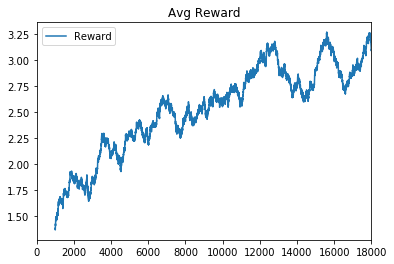

In [45]:
rew = pd.DataFrame(earned_rewards)
rew.columns = ['Reward']
rew.rolling(1000).mean().plot()
plt.title("Avg Reward")


### 2) Evaluate the trained model on the remaining rows of the data and plot the regret for them.

In [46]:
regret = [] #track regret
for i in range(len(test_data)):
    context = test_data[i][:context_size] # X
    obs = test_data[i][context_size:] # y
    
    pred_upper = [] # track predicted rewards
    for j in range(arms):
        A_prime = np.linalg.inv(A[j])
        theta[j] = np.matmul(A_prime, b[j])
        
        expected_val = np.matmul(np.transpose(theta[j]), context)
        cb = alpha * np.sqrt(np.matmul(np.matmul(np.transpose(context), A_prime), context))
        pred_upper.append(expected_val + cb)
    
    max_ep = epsilon_select(pred_upper, 1) # with eps=1, this is always on-policy
    user_regret = np.max(obs) - obs[max_ep]
    regret.append(user_regret)

Average Regret:  4.762658763759527


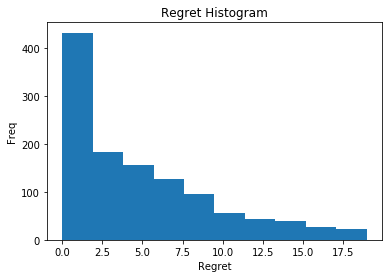

In [47]:
# regret hist
print('Average Regret: ', np.mean(regret))
plt.hist(regret)
plt.title('Regret Histogram')
plt.xlabel('Regret')
plt.ylabel('Freq')
plt.show()